# Training a ResNet using Keras
The following code implements a ResNet of 50 layers using Keras on the PlantVillage dataset, which consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease.

In [ ]:
# Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')

## 1 Building ResNet Blocks
Every ResNet block consists of an identity block and a convolutional block.

### 1.1 Identity Block

In [ ]:
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
# Defining the identity block
def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor
    f -- integer specifying the shape of the middle CONV's kernel
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer used to name the layers, depending on their positions in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block
    """

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieving filters
    f1,f2,f3 = filters

    # Saving the input value
    X_short = X

    # Building the first component of the main path
    X = tf.keras.layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='valid',name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Building the second component of the main path
    X = tf.keras.layers.Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding='same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Building the third component of the main path
    X = tf.keras.layers.Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2c')(X)

    # Final component
    X = tf.keras.layers.Add()([X,X_short])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [ ]:
# Testing the identity block
X = tf.random.normal((1,256,256,3))
identity_block(X,3,[3,3,3],1,'a')

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[8.2510239e-01, 8.4630620e-01, 3.1012887e-01],
         [1.8564922e-01, 2.0246243e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 4.2182884e-01, 2.2319677e-01],
         [0.0000000e+00, 9.6823412e-01, 0.0000000e+00],
         [2.9512815e+00, 0.0000000e+00, 1.9504287e+00]],

        [[3.0543488e-03, 2.5732577e-01, 1.1137931e+00],
         [1.3819411e+00, 0.0000000e+00, 2.7503887e-01],
         [1.1408516e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.0683779e+00, 0.0000000e+00, 9.5688099e-01],
         [0.0000000e+00, 0.0000000e+00, 4.4387048e-01]],

        [[0.0000000e+00, 5.6252456e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [8.7330061e-01, 0.0000000e+00, 1.1308697e+00],
         ...,
         [1.4997827e+00, 4.5054978e-01, 1.9506207e+00],


### 1.2 Convolutional Block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    f1,f2,f3 = filters

    # Save the input value
    X_short = X

    # First component of the main path
    X = tf.keras.layers.Conv2D(filters=f1,kernel_size=(1,1),strides=(s,s),padding='valid',name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Second component of the main path
    X = tf.keras.layers.Conv2D(filters=f2,kernel_size=(1,1),strides=(1,1),padding='same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('relu')(X)

    # Third component of the main path
    X = tf.keras.layers.Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_short = tf.keras.layers.Conv2D(filters=f3,kernel_size=(1,1),strides=(s,s),padding='valid',name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_short)
    X_short = tf.keras.layers.BatchNormalization(axis = -1, name = bn_name_base + '1')(X_short)

    # Final step
    X = tf.keras.layers.Add()([X,X_short])
    X = tf.keras.layers.Activation('relu')(X)

    return X

In [ ]:
# Testing the convolutional block
convolutional_block(X,3,[8,8,8],1,'a')

<tf.Tensor: shape=(1, 128, 128, 8), dtype=float32, numpy=
array([[[[0.58159125, 0.24642763, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.02269331, 0.10342281, 0.12545165, ..., 0.        ,
          0.0866431 , 0.1368264 ],
         [0.        , 0.54562795, 1.0073454 , ..., 1.2334616 ,
          0.9890927 , 0.        ],
         ...,
         [1.517161  , 0.3468545 , 0.        , ..., 0.        ,
          0.        , 0.43026656],
         [2.3577566 , 0.02041095, 0.        , ..., 0.        ,
          0.        , 0.8743483 ],
         [1.4902083 , 0.        , 0.        , ..., 0.        ,
          0.        , 0.573305  ]],

        [[0.5854722 , 0.772046  , 0.3357129 , ..., 0.        ,
          0.08130588, 0.84706825],
         [0.        , 0.37311524, 0.4968412 , ..., 1.1192389 ,
          0.72337675, 0.        ],
         [1.3089738 , 0.41631114, 0.        , ..., 0.        ,
          0.        , 0.62670094],
         ...,
         [0.44379258, 0.      

## 2 Building the ResNet-50 Model
The ResNet-50 model has 5 stages with convolutional and identity layers.

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):

  X_input = tf.keras.layers.Input(input_shape)

  # Zero padding of input
  X = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(X_input)

  # Stage 1
  X = tf.keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = tf.keras.layers.BatchNormalization(axis = -1, name = 'bn_conv1')(X)
  X = tf.keras.layers.Activation('relu')(X)
  X = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)

  # Stage 2
  X = convolutional_block(X,3,[64,64,256],2,'a',s=1)
  X = identity_block(X,3,[64,64,256],2,'b')
  X = identity_block(X,3,[64,64,256],2,'c')

  # Stage 3
  X = convolutional_block(X,3,[128,128,512],3,'a',s=2)
  X = identity_block(X,3,[128,128,512],3,'b')
  X = identity_block(X,3,[128,128,512],3,'c')
  X = identity_block(X,3,[128,128,512],3,'d')

  # Stage 4
  X = convolutional_block(X,3,[256,256,1024],4,'a',s=2)
  X = identity_block(X,3,[256,256,1024],4,'b')
  X = identity_block(X,3,[256,256,1024],4,'c')
  X = identity_block(X,3,[256,256,1024],4,'d')
  X = identity_block(X,3,[256,256,1024],4,'e')
  X = identity_block(X,3,[256,256,1024],4,'f')

  # Stage 5
  X = convolutional_block(X,3,[512,512,2048],5,'a',s=2)
  X = identity_block(X,3,[512,512,2048],5,'b')
  X = identity_block(X,3,[512,512,2048],5,'c')

  #Output
  X = tf.keras.layers.AveragePooling2D(name='avg_pool')(X)
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(classes,activation='softmax',name ='fc' + str(classes),kernel_initializer = glorot_uniform(seed=0))(X)

  model = tf.keras.Model(inputs = X_input,outputs = X, name = 'ResNet50')

  return model

In [ ]:
model = ResNet50(input_shape=(64,64,3),classes=38)

## 3 Visualising the Model Architecture

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

## 4 Loading the Data
The dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease.

In [ ]:
# Loading the data
dataset = tfds.load('plant_village',split='train', shuffle_files=True, as_supervised=True)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
dataset = dataset.map(lambda img,cls: (tf.image.resize(img/255,(64,64)),cls))
dataset = dataset.batch(8)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Splitting the dataset into train and test sets
train_data = dataset.skip(625)
test_data = dataset.take(625)

Shape: (8, 64, 64, 3)
Class: 11


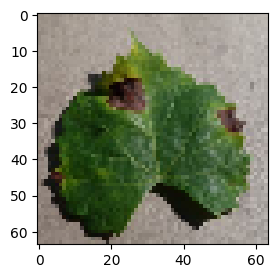

In [ ]:
# Viewing the data
itr = train_data.as_numpy_iterator()
img,cls = next(itr)
print('Shape:',img.shape)

print('Class:',cls[0])
fig,ax = plt.subplots(1,1,figsize=[3,3])
ax.imshow(img[0])
fig.show()

## 5 Training the ResNet-50 Model

In [ ]:
# Specifying the training configuration
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# Fitting the model on the training data
history = model.fit(train_data,epochs=3)

Epoch 1/3
6163/6163 [==============================] - 340s 47ms/step - loss: 1.9354 - sparse_categorical_accuracy: 0.4990
Epoch 2/3
6163/6163 [==============================] - 289s 46ms/step - loss: 0.8897 - sparse_categorical_accuracy: 0.7224
Epoch 3/3
6163/6163 [==============================] - 287s 46ms/step - loss: 0.5638 - sparse_categorical_accuracy: 0.8205


In [ ]:
history.history

{'loss': [1.9354093074798584, 0.8897064924240112, 0.5637920498847961],
 'sparse_categorical_accuracy': [0.4989554286003113,
  0.7224307060241699,
  0.8204571604728699]}

## 6 Evaluating the Model on the Test Data

In [ ]:
# Calculating the test loss and accuracy
model.evaluate(test_data)

625/625 [==============================] - 10s 13ms/step - loss: 1.4301 - sparse_categorical_accuracy: 0.7702


[1.4301254749298096, 0.7702000141143799]

In [ ]:
# Generating predictions for 8 samples
itr_test = test_data.as_numpy_iterator()
img,cls = next(itr_test)

In [ ]:
# Actual classes
cls

array([24, 28,  3, 27, 27,  4, 24, 15])

In [ ]:
# Predicted classes
cls_preds = model.predict(img)
np.argmax(cls_preds,1)

1/1 [==============================] - 1s 939ms/step


array([24, 28, 24, 27, 10,  4, 24, 15])

## 7 Conclusion
Thus, the final ResNet-50 model has over 40M parameters and achieved training and test accuracies of 82.04% and 77.02%, respectively.